In [123]:
import pandas as pd
import pickle
import numpy as np
import datetime

import urllib
import cStringIO
import Image

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.decomposition import RandomizedPCA,PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.lda import LDA
from sklearn.qda import QDA

from sklearn.pipeline import make_pipeline
# from sklearn import svm
from scipy.stats import mode
from sklearn.cross_validation import cross_val_score

import seaborn as sns
from seaborn import plt

%matplotlib inline

In [2]:
train = pd.DataFrame(pickle.load(open('/Volumes/flash/compology/image_data/train_gl_nn_data.pickle','r')))

In [3]:
test = pd.DataFrame(pickle.load(open('/Volumes/flash/compology/image_data/test_gl_nn_data.pickle','r')))

In [4]:
class ProcessTimer:
  def __init__(self):
    self.startTime = datetime.datetime.now()
  def start(self,functionResponse,name=""):
    endTime = datetime.datetime.now()
    self.delta = (endTime - self.startTime)
    print "{} Time |{}|".format(name,self.delta.seconds)
    return functionResponse

In [5]:
X_train = list(train['pixel_data'][:].values)
y_train = list(train['label'][:].values)

X_test = list(test['pixel_data'].values)
y_test = list(test['label'].values)
print len(X_train),len(X_test)

12087 5181


In [6]:
pca = PCA(n_components=200)
X_train = pca.fit_transform(list(train['pixel_data'].values))
X_test = pca.transform(list(test['pixel_data'].values))

# Ensemble Tests

In [110]:
models = [
    {'baseclf': LDA(),'name': 'LinearDiscriminantAnalysis'},
#     {'baseclf': SVC(kernel="linear", C=0.025,probability=True),'name':"SupportVectorClassifier"},
    {'baseclf': LogisticRegression(C=0.1,class_weight='auto',penalty='l2'),'name': "LogisticRegression"},
    {'baseclf': KNeighborsClassifier(45, weights='distance'),'name': "KNeighborsClassifier"},
    {'baseclf': QDA(),'name': 'QuadraticDiscriminantAnalysis'},
    {'baseclf': GaussianNB(),'name': "GaussianNB"},
    {'baseclf': RandomForestClassifier(n_estimators=30,max_depth=None, random_state=1),'name': "RandomForestClassifier"},
    {'baseclf': AdaBoostClassifier(n_estimators=30,random_state=1),'name': "AdaBoostClassifier"},
    {'baseclf': DecisionTreeClassifier(max_depth=6, random_state=1),'name': "DecisionTreeClassifier"}

]

In [154]:
class EnsembleClassifier:
    def __init__(self,classifiers,preprocessing=None):
        self.classifiers = classifiers[:]
        self.preprocessing = preprocessing
        self.predictions = {'classifiers': [],'classes': [],'prob':[],'mean_prob':[],'class_dict':[]}
            
    def fit(self,xtrain,ytrain):
        for model in self.classifiers:
#             if self.preprocessing: model['clf'] = make_pipeline(self.preprocessing,model['baseclf'])
#             else:
            model['clf'] = model['baseclf']
            ProcessTimer().start(
                model['clf'].fit(xtrain,ytrain),
            name=model['name'])
    
    def buildModelPredictionDict(self,xtest):
        for model in self.classifiers:
            self.predictions['classifiers'].append(model['name'])
            self.predictions['classes'].append( model['clf'].predict(xtest))
            
            probabilityValues = [round(v.max(),3) for v in model['clf'].predict_proba(xtest)]
            self.predictions['prob'].append( probabilityValues )

            meanProb = round(np.asarray(probabilityValues).mean(),3)
            self.predictions['mean_prob'].append(meanProb)            
            
        self.predictions['classes'] = map(list,zip(*self.predictions['classes']))
        self.predictions['prob'] = map(list,zip(*self.predictions['prob']))
        self.predictions['model_dict'] = self.buildClassifList(xtest)
        return self.predictions
    
    def buildClassifList(self,xtest):
        for i,v in enumerate(xtest):
            names = [x[:3] for x in self.predictions['classifiers']]
            classes = self.predictions['classes'][i]
            prob = self.predictions['prob'][i]
            mean_prob = [x for x in self.predictions['mean_prob']]
            keys = ('name','class','prob','mean_prob')
            classInfo = [dict(zip(keys,x)) for x in zip(names,classes,prob,mean_prob)]
            self.predictions['class_dict'].append(classInfo)
        return self.predictions['class_dict']
    
    def scoreAll(self,xtest,ytest):
        for model in self.classifiers:
            score = model['clf'].score(xtest,ytest)
            print round(score,4),"|",model['name']

    def getHighProbDict(self,xtest):
        classDict = self.predictions['model_dict']
        highProbDict = {'classes': [],'classifiers':[],'prediction':[]}
        for i,v in enumerate(xtest):
            highProbDict['classes'].append([x['class'] for x in classDict[i] if x['prob'] >= x['mean_prob']])
            highProbDict['classifiers'].append([x['name'] for x in classDict[i] if x['prob'] >= x['mean_prob']])
#             highProbDict['prediction'] = int(mode(highProbDict['classes'][i])[0][0])
        return highProbDict
        

    def transform(self,xtest,ytest):
        self


eclf = EnsembleClassifier(models,preprocessing=PCA(n_components=200))
eclf.fit(X_train,y_train);print
eclf.scoreAll(X_test,y_test)
# clf.score(X_test,y_test)
### Below represents processing time for fitting classifiers, and scores of each classifier

LinearDiscriminantAnalysis Time |0|
LogisticRegression Time |18|
KNeighborsClassifier Time |0|
QuadraticDiscriminantAnalysis Time |0|
GaussianNB Time |0|
RandomForestClassifier Time |7|
AdaBoostClassifier Time |13|
DecisionTreeClassifier Time |2|

0.4107 | LinearDiscriminantAnalysis
0.3797 | LogisticRegression
0.371 | KNeighborsClassifier
0.3577 | QuadraticDiscriminantAnalysis
0.3272 | GaussianNB
0.3096 | RandomForestClassifier
0.294 | AdaBoostClassifier
0.2884 | DecisionTreeClassifier


In [155]:
predictions = eclf.buildModelPredictionDict(X_test)
print predictions.keys()
print predictions['classifiers']
print predictions['mean_prob']
print predictions['model_dict'][0]

['class_dict', 'prob', 'classes', 'model_dict', 'mean_prob', 'classifiers']
['LinearDiscriminantAnalysis', 'LogisticRegression', 'KNeighborsClassifier', 'QuadraticDiscriminantAnalysis', 'GaussianNB', 'RandomForestClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier']
[0.64, 0.45, 0.404, 0.962, 0.62, 0.284, 0.104, 0.361]
[{'prob': 1.0, 'mean_prob': 0.64, 'name': 'Lin', 'class': 0}, {'prob': 0.899, 'mean_prob': 0.45, 'name': 'Log', 'class': 0}, {'prob': 0.864, 'mean_prob': 0.404, 'name': 'KNe', 'class': 0}, {'prob': 1.0, 'mean_prob': 0.962, 'name': 'Qua', 'class': 0}, {'prob': 1.0, 'mean_prob': 0.62, 'name': 'Gau', 'class': 0}, {'prob': 0.6, 'mean_prob': 0.284, 'name': 'Ran', 'class': 0}, {'prob': 0.112, 'mean_prob': 0.104, 'name': 'Ada', 'class': 0}, {'prob': 0.945, 'mean_prob': 0.361, 'name': 'Dec', 'class': 0}]


In [218]:
# highProbDict = eclf.getHighProbDict(X_test)
modePredictions = []
print [x[:10] for x in predictions['classifiers']]
for i,y in enumerate(y_test[:]):
    modeValue = int(mode(np.asarray(predictions['classes'][i]))[0][0])
    if i < 20:
        print y,"|",modeValue,"|",predictions['classes'][i]
    modePredictions.append(modeValue)

## y, pred_y, all_pred

['LinearDisc', 'LogisticRe', 'KNeighbors', 'QuadraticD', 'GaussianNB', 'RandomFore', 'AdaBoostCl', 'DecisionTr']
0 | 0 | [0, 0, 0, 0, 0, 0, 0, 0]
40 | 40 | [40, 40, 30, 40, 30, 40, 20, 30]
30 | 20 | [20, 20, 20, 20, 20, 30, 30, 30]
40 | 40 | [50, 50, 40, 40, 30, 30, 40, 50]
30 | 40 | [40, 40, 40, 40, 20, 30, 30, 30]
20 | 20 | [20, 20, 10, 20, 20, 20, 20, 10]
30 | 10 | [0, 0, 10, 10, 50, 10, 20, 20]
0 | 0 | [0, 0, 0, 0, 0, 0, 10, 0]
0 | 0 | [0, 0, 0, 0, 0, 0, 0, 0]
0 | 0 | [0, 0, 0, 0, 0, 0, 0, 0]
20 | 10 | [10, 10, 10, 20, 50, 10, 20, 20]
0 | 0 | [0, 0, 0, 0, 0, 0, 0, 10]
50 | 40 | [40, 40, 40, 40, 10, 40, 30, 50]
40 | 40 | [30, 60, 50, 40, 20, 40, 40, 30]
50 | 70 | [50, 60, 50, 70, 70, 40, 70, 80]
40 | 30 | [40, 40, 30, 40, 40, 30, 30, 30]
10 | 10 | [10, 10, 10, 10, 10, 10, 10, 10]
40 | 50 | [50, 50, 50, 30, 50, 30, 30, 50]
30 | 20 | [20, 20, 20, 20, 10, 20, 10, 20]
20 | 20 | [20, 20, 20, 20, 10, 10, 10, 20]


In [221]:
escore = float(sum(np.asarray(modePredictions) == np.asarray(y_test))) / float(len(y_test))
print "Score for Mode of ensemble Classifier: {:.4f}".format(escore)


Score for Mode of ensemble Classifier: 0.3926


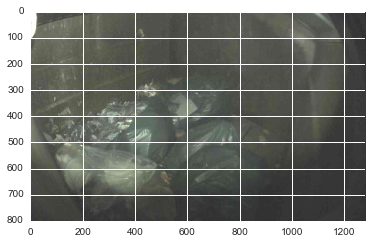

In [132]:
f = urllib.urlopen(test.img[18])
img = cStringIO.StringIO(f.read())
imgBase = Image.open(img)
plt.imshow(imgBase)

In [266]:
logPosition = 1
def scoreTests(predictionGroup,actual):
    logScores = [y == predictionGroup[i][logPosition] for  i,y in enumerate(actual)]
    print "Log score:",sum(logScores),"|",float(sum(logScores))/float(len(logScores))
    
    avg = lambda x: int(round(float(sum(x)/len(x))/10,0)*10)
    averages =  map(avg,predictionGroup)
    avgScores = [y == averages[i] for  i,y in enumerate(actual)]
    print "Avg score: ",sum(avgScores),"|",float(sum(avgScores))/float(len(avgScores))

    getMode = lambda x: int(mode(x)[0][0])
    modes = map(getMode,predictionGroup)
    modeScores = [y == modes[i] for  i,y in enumerate(actual)]
    print "Mode scores",sum(modeScores),"|",float(sum(modeScores))/float(len(modeScores))
    
    return [abs(y-actual[i]) for i,y in enumerate(modes)]
    

variances = scoreTests(prediction['values'],y_test)


Log score: 1967 | 0.379656436981
Avg score:  1932 | 0.372900984366
Mode scores 2034 | 0.392588303416


In [267]:
def calculateLabelVariances(variances):
    varDict = {}
    for v in variances:
        if v not in varDict:
            varDict[v] = 1
        else:
            varDict[v] += 1
    return varDict
variances[:10]

varScores = calculateLabelVariances(variances)
print varScores
print varScores[0],"",float(varScores[0])/ float(len(variances))
print varScores[10],"",float(varScores[10])/ float(len(variances))
print varScores[20],"",float(varScores[20])/ float(len(variances))

{0: 2034, 100: 2, 70: 15, 40: 87, 10: 1971, 80: 4, 50: 51, 20: 705, 90: 5, 60: 34, 30: 273}
2034  0.392588303416
1971  0.380428488709
705  0.136074116966


In [212]:
clfPip = make_pipeline(PCA(n_components=200),LogisticRegression(C=0.1,class_weight='auto',penalty='l2'))
print testClf
clfPip.fit(list(train['pixel_data'][:].values),list(train['label'][:].values))
print "PCA / LOG Pipeline score: {}".format(clfPip.score(list(test['pixel_data'][:].values),list(test['label'][:].values)))

Pipeline(steps=[('pca', PCA(copy=True, n_components=200, whiten=False)), ('logisticregression', LogisticRegression(C=0.1, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))])
PCA / LOG Pipeline score: 0.379656436981


In [70]:
df = test.copy()

In [132]:
def scoreModel(clf,df,X,y):
    pred = clf.predict(Xtest)
    prob = [x.max() for x in clf.predict_proba(Xtest)]
    df['pred'] = pred
    df['prob'] = prob
    df['variance'] = [abs(pred[i] - x) for i,x in enumerate(df.label.values)]
    dfv = df['variance'].value_counts(sort=False,normalize=True).sort_index()
    var0 = dfv.values[0]*100
    var10 = dfv.values[1]*100
    var20 = dfv.values[2]*100
    varGreater = (100 - var0 - var10 - var20)
    print "0: {:.1f}% | 10: {:.1f}% | 20: {:.1f}% | greater error: {:.1f}%".format(var0,var10,var20,varGreater)
    print "Average probability |{}|".format(df['prob'].mean())
    print "Mean |{}|".format(df['variance'].mean())
    
    dfp = df[df.prob > (df['prob'].mean()*0.7)]
    dfv = dfp['variance'].value_counts(sort=False,normalize=True).sort_index()
    var0 = dfv.values[0]*100
    var10 = dfv.values[1]*100
    var20 = dfv.values[2]*100
    varGreater = (100 - var0 - var10 - var20)
    print float(len(dfp))/float(len(df))
    print "0: {:.1f}% | 10: {:.1f}% | 20: {:.1f}% | greater error: {:.1f}%".format(var0,var10,var20,varGreater)
    
    return df
print models.keys()

['knn', 'gnb', 'abc', 'log', 'dtc', 'rfc']
